<a href="https://colab.research.google.com/github/kridtapon/TempoFlow-Alignment/blob/main/TempoFlow_Alignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.6/527.6 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.7/295.7 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 41.5 MB/s eta 0:00:00


In [ ]:
pip install --upgrade yfinance

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt

# -------------------------------
# Indicator functions
# -------------------------------
def add_indicators(df):
    df['EMA20'] = df['Close'].ewm(span=20).mean()
    df['EMA50'] = df['Close'].ewm(span=50).mean()
    return df

# -------------------------------
# Download Data
# -------------------------------
symbol = 'RSG'
start_date = '2015-01-01'
end_date = '2025-01-01'

# Weekly and Daily data
weekly = yf.download(symbol, start=start_date, end=end_date, interval='1wk')
daily = yf.download(symbol, start=start_date, end=end_date, interval='1d')
weekly.columns = ['Close', 'High', 'Low', 'Open', 'Volume']
daily.columns = ['Close', 'High', 'Low', 'Open', 'Volume']

weekly = add_indicators(weekly)
daily = add_indicators(daily)

# -------------------------------
# Resample Weekly trend to Daily
# -------------------------------
weekly_trend = weekly['EMA20'] > weekly['EMA50']
weekly_trend = weekly_trend.reindex(daily.index, method='ffill')

# -------------------------------
# Define Entry/Exit Signals
# -------------------------------
daily_trend = daily['EMA20'] > daily['EMA50']

entry = weekly_trend & daily_trend

exit = (
    (daily['EMA20'] < daily['EMA50'])
)

# Filter data for the test period (2020-2025)
daily = daily[(daily.index.year >= 2020) & (daily.index.year <= 2025)]
entry = entry[(entry.index.year >= 2020) & (entry.index.year <= 2025)]
exit = exit[(exit.index.year >= 2020) & (exit.index.year <= 2025)]

# -------------------------------
# Backtest
# -------------------------------
portfolio = vbt.Portfolio.from_signals(
    close=daily['Close'],
    entries=entry,
    exits=exit,
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='D'
)

# -------------------------------
# Results
# -------------------------------
print(portfolio.stats())
portfolio.plot().show()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Start                                2020-01-02 00:00:00
End                                  2024-12-31 00:00:00
Period                                1258 days 00:00:00
Start Value                                     100000.0
End Value                                   147075.47708
Total Return [%]                               47.075477
Benchmark Return [%]                           140.49154
Max Gross Exposure [%]                             100.0
Total Fees Paid                              2299.055233
Max Drawdown [%]                               23.999285
Max Drawdown Duration                  531 days 00:00:00
Total Trades                                          11
Total Closed Trades                                   11
Total Open Trades                                      0
Open Trade PnL                                       0.0
Win Rate [%]                                   36.363636
Best Trade [%]                                 38.277463
Worst Trade [%]                

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Best Fast EMA Span: 47
Best Slow EMA Span: 84
Best Total Return [%]: 120.3947699777753


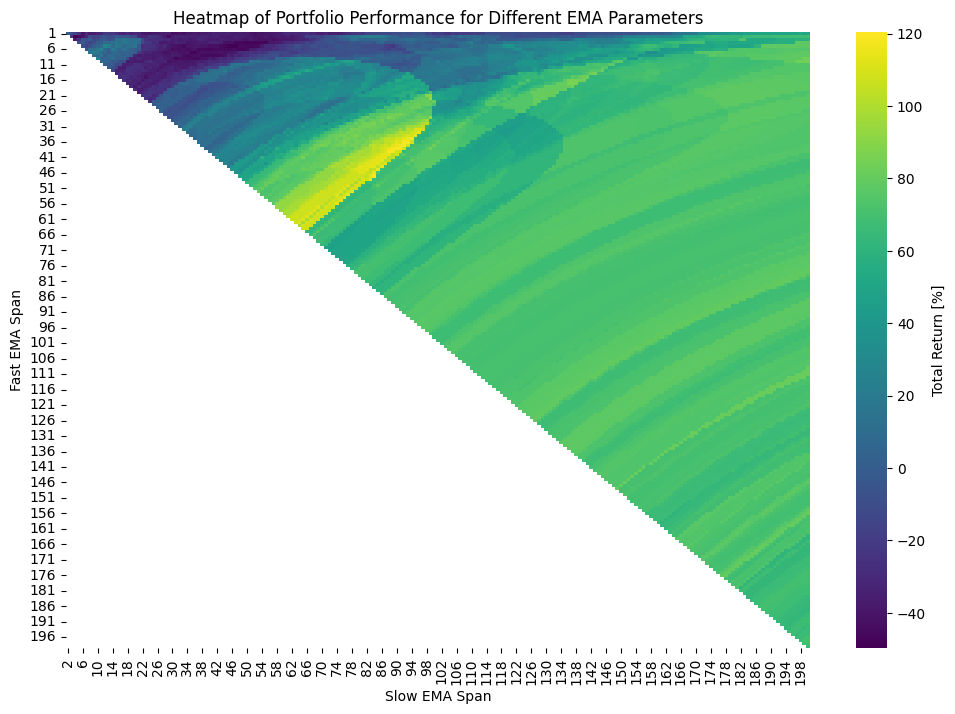


Portfolio Stats:
Start                         2020-01-02 00:00:00
End                           2024-12-31 00:00:00
Period                         1258 days 00:00:00
Start Value                              100000.0
End Value                           220394.769978
Total Return [%]                        120.39477
Benchmark Return [%]                    83.504223
Max Gross Exposure [%]                      100.0
Total Fees Paid                        863.483616
Max Drawdown [%]                        19.385817
Max Drawdown Duration           430 days 00:00:00
Total Trades                                    3
Total Closed Trades                             3
Total Open Trades                               0
Open Trade PnL                                0.0
Win Rate [%]                                100.0
Best Trade [%]                          47.323768
Worst Trade [%]                         21.858686
Avg Winning Trade [%]                   30.676988
Avg Losing Trade [%]            

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import vectorbt as vbt

# -------------------------------
# Indicator functions
# -------------------------------
def add_indicators(df, fast_span, slow_span):
    df['Fast_EMA'] = df['Close'].ewm(span=fast_span).mean()
    df['Slow_EMA'] = df['Close'].ewm(span=slow_span).mean()
    return df

# -------------------------------
# Download Data
# -------------------------------
symbol = 'VRTX'
start_date = '2015-01-01'
end_date = '2025-01-01'

# Weekly and Daily data
weekly = yf.download(symbol, start=start_date, end=end_date, interval='1wk')
daily = yf.download(symbol, start=start_date, end=end_date, interval='1d')
weekly.columns = ['Close', 'High', 'Low', 'Open', 'Volume']
daily.columns = ['Close', 'High', 'Low', 'Open', 'Volume']

# -------------------------------
# Optimization Process
# -------------------------------
# Define range for Fast and Slow EMA spans
fast_range = range(1, 201)  # Fast EMA range from 1 to 200
slow_range = range(1, 201)  # Slow EMA range from 1 to 200

# Prepare an empty list to store the results
results = []

# Loop through all combinations of fast and slow EMA spans
for fast_span, slow_span in itertools.product(fast_range, slow_range):
    # Avoid cases where Fast EMA is greater than or equal to Slow EMA
    if fast_span >= slow_span:
        continue

    # Add the calculated EMAs to the daily data
    daily_data = add_indicators(daily.copy(), fast_span, slow_span)
    weekly_data = add_indicators(weekly.copy(), fast_span, slow_span)

    # Define the trends and signals
    daily_trend = daily_data['Fast_EMA'] > daily_data['Slow_EMA']
    weekly_trend = weekly_data['Fast_EMA'] > weekly_data['Slow_EMA']
    weekly_trend = weekly_trend.reindex(daily.index, method='ffill')
    entry = weekly_trend & daily_trend
    exit = (daily_data['Fast_EMA'] < daily_data['Slow_EMA'])

    # Filter data for the test period (2020-2025)
    daily_data = daily_data[(daily_data.index.year >= 2020) & (daily_data.index.year <= 2025)]
    entry = entry[(entry.index.year >= 2020) & (entry.index.year <= 2025)]
    exit = exit[(exit.index.year >= 2020) & (exit.index.year <= 2025)]

    # Backtest the portfolio
    portfolio = vbt.Portfolio.from_signals(
        close=daily_data['Close'],
        entries=entry,
        exits=exit,
        init_cash=100_000,
        fees=0.001,
        slippage=0.002,
        freq='D'
    )

    # Store the result (Total Return [%])
    results.append({
        'fast_span': fast_span,
        'slow_span': slow_span,
        'total_return': portfolio.stats()['Total Return [%]'],
        'portfolio': portfolio
    })

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)

# Find the best performing parameter set based on total return
best_params = results_df.loc[results_df['total_return'].idxmax()]

# Get the best parameters and their portfolio
best_fast_span = best_params['fast_span']
best_slow_span = best_params['slow_span']
best_total_return = best_params['total_return']
best_portfolio = best_params['portfolio']

# Print the best parameters and the corresponding portfolio stats
print(f"Best Fast EMA Span: {best_fast_span}")
print(f"Best Slow EMA Span: {best_slow_span}")
print(f"Best Total Return [%]: {best_total_return}")

# -------------------------------
# Plot the heatmap
# -------------------------------
heatmap_data = results_df.pivot(index='fast_span', columns='slow_span', values='total_return')

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='viridis', cbar_kws={'label': 'Total Return [%]'})
plt.title('Heatmap of Portfolio Performance for Different EMA Parameters')
plt.xlabel('Slow EMA Span')
plt.ylabel('Fast EMA Span')
plt.show()

# -------------------------------
# Show the best portfolio plot
# -------------------------------
best_portfolio.plot().show()
print("\nPortfolio Stats:")
print(best_portfolio.stats())